## Load Packages

In [198]:
# Date and time
import os
# import matplotlib.pyplot as plt
# import matplotlib.ticker as ticker
# import seaborn as sns

import numpy as np
import pandas as pd
import simplejson as json

# CityLearn
from citylearn.citylearn import CityLearnEnv
from citylearn.data import DataSet
from citylearn.reward_function import RewardFunction
from citylearn.reward_function import SolarPenaltyReward
from citylearn.wrappers import NormalizedObservationWrapper
from citylearn.wrappers import StableBaselines3Wrapper
from citylearn.wrappers import DiscreteSpaceWrapper


from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3 import A2C
from stable_baselines3 import PPO
from stable_baselines3 import SAC
# from stable_baselines3 import DQN


from plots import plot_actions, plot_soc

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [7]:
DataSet.get_names()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['citylearn_challenge_2020_climate_zone_1',
 'citylearn_challenge_2020_climate_zone_2',
 'citylearn_challenge_2020_climate_zone_3',
 'citylearn_challenge_2020_climate_zone_4',
 'citylearn_challenge_2021',
 'citylearn_challenge_2022_phase_1',
 'citylearn_challenge_2022_phase_2',
 'citylearn_challenge_2022_phase_3',
 'citylearn_challenge_2022_phase_all']

In [258]:
schema = DataSet.get_schema('citylearn_challenge_2022_phase_all')


In [259]:
schema

{'root_directory': '/usr/local/lib/python3.10/dist-packages/citylearn/data/citylearn_challenge_2022_phase_all',
 'central_agent': False,
 'simulation_start_time_step': 0,
 'simulation_end_time_step': 8759,
 'episodes': 1,
 'seconds_per_time_step': 3600,
 'observations': {'month': {'active': True, 'shared_in_central_agent': True},
  'day_type': {'active': True, 'shared_in_central_agent': True},
  'hour': {'active': True, 'shared_in_central_agent': True},
  'daylight_savings_status': {'active': False,
   'shared_in_central_agent': True},
  'outdoor_dry_bulb_temperature': {'active': True,
   'shared_in_central_agent': True},
  'outdoor_dry_bulb_temperature_predicted_6h': {'active': True,
   'shared_in_central_agent': True},
  'outdoor_dry_bulb_temperature_predicted_12h': {'active': True,
   'shared_in_central_agent': True},
  'outdoor_dry_bulb_temperature_predicted_24h': {'active': True,
   'shared_in_central_agent': True},
  'outdoor_relative_humidity': {'active': True,
   'shared_in_cen

In [260]:
# Building Data
# 1 to 17 building
building_name = 'Building_5'
file = schema['buildings'][building_name]['energy_simulation']
path = os.path.join(schema['root_directory'],file)
data = pd.read_csv(path)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 12 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Month                                          8760 non-null   float64
 1   Hour                                           8760 non-null   float64
 2   Day Type                                       8760 non-null   float64
 3   Daylight Savings Status                        8760 non-null   int64  
 4   Indoor Temperature [C]                         0 non-null      float64
 5   Average Unmet Cooling Setpoint Difference [C]  0 non-null      float64
 6   Indoor Relative Humidity [%]                   0 non-null      float64
 7   Equipment Electric Power [kWh]                 8760 non-null   float64
 8   DHW Heating [kWh]                              8760 non-null   int64  
 9   Cooling Load [kWh]                             8760 

In [261]:
# Weather Data
file = schema['buildings'][building_name]['weather']
path = os.path.join(schema['root_directory'],file)
weather_df = pd.read_csv(path)
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 16 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Outdoor Drybulb Temperature [C]                 8760 non-null   float64
 1   Relative Humidity [%]                           8760 non-null   float64
 2   Diffuse Solar Radiation [W/m2]                  8760 non-null   float64
 3   Direct Solar Radiation [W/m2]                   8760 non-null   float64
 4   6h Prediction Outdoor Drybulb Temperature [C]   8760 non-null   float64
 5   12h Prediction Outdoor Drybulb Temperature [C]  8760 non-null   float64
 6   24h Prediction Outdoor Drybulb Temperature [C]  8760 non-null   float64
 7   6h Prediction Relative Humidity [%]             8760 non-null   float64
 8   12h Prediction Relative Humidity [%]            8760 non-null   float64
 9   24h Prediction Relative Humidity [%]     

In [262]:
# Electricity price
file = schema['buildings'][building_name]['pricing']
path = os.path.join(schema['root_directory'],file)
price_df = pd.read_csv(path)
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Electricity Pricing [$]                 8760 non-null   float64
 1   6h Prediction Electricity Pricing [$]   8760 non-null   float64
 2   12h Prediction Electricity Pricing [$]  8760 non-null   float64
 3   24h Prediction Electricity Pricing [$]  8760 non-null   float64
dtypes: float64(4)
memory usage: 273.9 KB


## Data Preprocessing

In [263]:
# Only using 2 buildings 
np.random.seed(0)

buildings = list(schema['buildings'].keys())
buildings = buildings[1:3]
print(buildings)
for b in schema['buildings']:
    if b in buildings:
        schema['buildings'][b]['include'] = True
    else:
        schema['buildings'][b]['include'] = False

['Building_2', 'Building_3']


In [296]:
## simulation period
days = 7

file = schema['buildings'][building_name]['carbon_intensity']
filepath = os.path.join(schema['root_directory'], file)
time_steps = pd.read_csv(filepath).shape[0]

start_time = np.arange(0, time_steps, 24*days)
# print(simulation_start_time_step_list)
start_time_step = np.random.choice(start_time, size=1)[0]
end_time_step = start_time_step + 24*days - 1

schema['simulation_start_time_step'] = start_time_step
schema['simulation_end_time_step'] = end_time_step

print(f'Simulation for {days}-days:',(start_time_step, end_time_step))

Selected 7-day period time steps: (5544, 5711)


In [297]:
# active_obs = ['hour','outdoor_dry_bulb_temperature','outdoor_relative_humidity','electricity_pricing',
#               'net_electricity_consumption','electrical_storage_soc','dhw_storage_soc','heating_storage_soc',
#               'cooling_storage_soc','indoor_relative_humidity','indoor_dry_bulb_temperature','carbon_intensity','diffuse_solar_irradiance',
#               'direct_solar_irradiance','month','day_type']

# active_obs = ['month', 'day_type', 'hour', 'daylight_savings_status', 'outdoor_dry_bulb_temperature',
#               'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h',
#               'outdoor_dry_bulb_temperature_predicted_24h', 'outdoor_relative_humidity', 'outdoor_relative_humidity_predicted_6h',
#               'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 'diffuse_solar_irradiance',
#               'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h',
#               'direct_solar_irradiance', 'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h',
#               'direct_solar_irradiance_predicted_24h', 'carbon_intensity','electricity_pricing']

active_obs = ['month', 'hour', 'day_type','outdoor_dry_bulb_temperature','outdoor_relative_humidity', 'diffuse_solar_irradiance','direct_solar_irradiance']

for obs in schema['observations']:
    if obs in active_obs:
        schema['observations'][obs]['active'] = True
    else:
        schema['observations'][obs]['active'] = False

In [298]:
schema['actions']

{'cooling_storage': {'active': False},
 'heating_storage': {'active': False},
 'dhw_storage': {'active': False},
 'electrical_storage': {'active': True}}

In [299]:
# schema['observations']
# single agent whose goal is to optimize energy use and storage across multiple buildings
schema['central_agent'] = True

In [300]:
schema['reward_function']

{'type': 'citylearn.reward_function.RewardFunction', 'attributes': None}

In [301]:
# Initialize environment
env = CityLearnEnv(schema)

In [302]:
print('Active observations:')
data = []

for b in env.buildings:
    row = {'building': b.name}
    row.update(b.observation_metadata)
    data.append(row)

df = pd.DataFrame(data)
display(df)

Active observations:


,building,month,day_type,hour,outdoor_dry_bulb_temperature,outdoor_relative_humidity,diffuse_solar_irradiance,direct_solar_irradiance
0,Building_2,True,True,True,True,True,True,True
1,Building_3,True,True,True,True,True,True,True


In [303]:
print('Active actions:')
data = []

for b in env.buildings:
    row = {'building': b.name}
    row.update(b.action_metadata)
    data.append(row)

df = pd.DataFrame(data)
display(df)

Active actions:


,building,electrical_storage
0,Building_2,True
1,Building_3,True


## CityLearn Baseline using SAC

In [306]:
sac_env = CityLearnEnv(schema)
sac_env = NormalizedObservationWrapper(sac_env)
sac_env = StableBaselines3Wrapper(sac_env)
sac_model = SAC(policy='MlpPolicy', env=sac_env, seed=0)

class Callback(BaseCallback):
    def __init__(self, env:CityLearnEnv):
        super().__init__(verbose=0)
        self.env = env
        self.reward_history = [0]
    ## keep track of the rewards
    def _on_step(self) -> bool:
        if self.env.time_step == 0:
            self.reward_history.append(0)
        else:
            self.reward_history[-1] += sum(self.env.rewards[-1])
        return True

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning:

WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



In [307]:
sac_callback = Callback(sac_env)
sac_model = sac_model.learn(total_timesteps=20000,callback=sac_callback)

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning:

WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.



In [309]:
## SAVE THE MODEL
# sac_model.save('sac_model1')

# Load Model
# sac_model = SAC.load('sac_model1', sac_env)

In [310]:
sac_callback.reward_history

[-242.64807050410693,
 -224.11530305129733,
 -222.44137788262017,
 -212.44709888476405,
 -207.28770122135361,
 -212.56186925440366,
 -203.8764576622774,
 -195.79828813574218,
 -212.4911020109736,
 -196.69249906016654,
 -194.3127451431929,
 -189.84232992189254,
 -195.74739875833495,
 -194.71480886442953,
 -187.5499932565956,
 -177.0567630480746,
 -190.81255757191005,
 -185.93134238977044,
 -188.045158789669,
 -183.9867194733639,
 -179.02780595849558,
 -182.55738813526432,
 -176.39001600894147,
 -177.3935876386819,
 -182.7138454182803,
 -176.86122546087387,
 -179.34728037597816,
 -179.12822877928429,
 -177.20924048001132,
 -179.150508802994,
 -174.9009546995927,
 -169.55499130438247,
 -175.41743766673838,
 -174.46533579051209,
 -181.4164991734998,
 -176.09137355961033,
 -177.51026870766663,
 -175.42072756364868,
 -178.1878155650113,
 -176.69331502607702,
 -174.44411845498018,
 -173.1889524905508,
 -175.79638646439147,
 -170.74566291405142,
 -172.49165099205368,
 -173.59121084256898,
 -17

In [311]:
obs = sac_env.reset()
sac_actions_list = []

while not sac_env.done:
    actions, _ = sac_model.predict(obs, deterministic=True)
    obs, _, _, _ = sac_env.step(actions)
    sac_actions_list.append(actions)


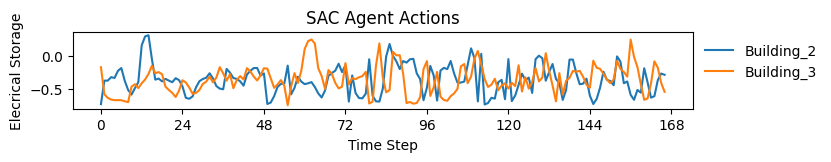

In [312]:
sac_actions_list
plot_actions(sac_actions_list,'SAC')

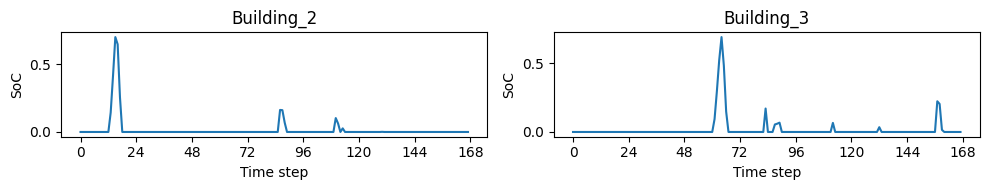

In [314]:
plot_soc(sac_env)

In [316]:
## KPIs
kpis = sac_env.evaluate()
kpi_name = ['electricity_consumption', 'cost', 'carbon_emissions','average_daily_peak', 'ramping', '1 - load_factor']
kpis = kpis[(kpis['cost_function'].isin(kpi_name))].dropna()
kpis['value'] = kpis['value'].round(3)
kpis = kpis.rename(columns={'cost_function': 'kpi'})
kpis

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:517: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



,kpi,value,name,level
0,1 - load_factor,0.997,District,district
1,average_daily_peak,1.000,District,district
2,carbon_emissions,0.990,District,district
3,cost,0.981,District,district
4,electricity_consumption,0.992,District,district
6,ramping,1.027,District,district
8,electricity_consumption,0.987,Building_2,building
10,carbon_emissions,0.985,Building_2,building
11,cost,0.977,Building_2,building
12,electricity_consumption,0.997,Building_3,building


## Changing reward function

In [318]:
sac2_env = CityLearnEnv(schema)
sac2_env.reward_function = SolarPenaltyReward(sac2_env)
sac2_env = NormalizedObservationWrapper(sac2_env)
sac2_env = StableBaselines3Wrapper(sac2_env)
sac_model2 = SAC(policy='MlpPolicy', env=sac2_env, seed=0)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning:

WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



In [319]:
sac2_callback = Callback(sac2_env)
sac_model2 = sac_model2.learn(total_timesteps=20000,callback=sac2_callback)

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning:

WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.



In [230]:
sac_model2.save('sac_model2')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [320]:
sac2_callback.reward_history

[-192.03908989050802,
 -166.10655266515906,
 -142.52789402119288,
 -145.9182898484949,
 -149.116454310391,
 -145.92905280933678,
 -141.5883171703023,
 -139.55648999514375,
 -142.71952080274605,
 -119.65596097749328,
 -116.07695886043176,
 -123.57448248859467,
 -131.438188479053,
 -147.9619341372342,
 -120.33445628253453,
 -115.88780699348652,
 -123.75947622957406,
 -120.7459909246455,
 -106.13883104496912,
 -106.28938622906267,
 -99.74413384652375,
 -106.70550507957219,
 -101.83738835505558,
 -92.76103508642088,
 -109.75285017289475,
 -100.9516843113941,
 -90.88519153112043,
 -85.0384349600565,
 -85.91714869859153,
 -94.24636446093555,
 -88.05404125614025,
 -81.63869642038723,
 -83.70100676432743,
 -92.66861123891715,
 -88.37547734269482,
 -86.65204636271193,
 -83.18328158755382,
 -80.77099186299351,
 -84.14336873286945,
 -82.81653278413398,
 -68.28149576742638,
 -70.63537693175493,
 -73.32547877118377,
 -69.40899517776785,
 -66.27226174912698,
 -71.78775973517315,
 -66.88502457591093,

In [321]:
obs = sac2_env.reset()
sac_actions_list2 = []

while not sac2_env.done:
    actions, _ = sac_model2.predict(obs, deterministic=True)
    obs, _, _, _ = sac2_env.step(actions)
    sac_actions_list2.append(actions)


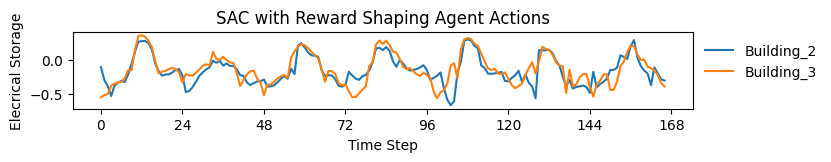

In [322]:
sac_actions_list2
plot_actions(sac_actions_list2,'SAC with Reward Shaping')

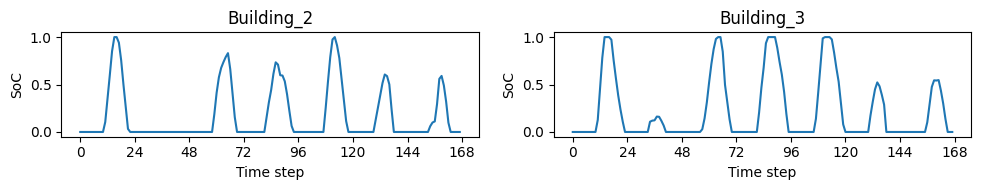

In [323]:
plot_soc(sac2_env)

In [324]:
## KPIs
kpis = sac2_env.evaluate()
kpi_name = ['electricity_consumption', 'cost', 'carbon_emissions','average_daily_peak', 'ramping', '1 - load_factor']
kpis = kpis[(kpis['cost_function'].isin(kpi_name))].dropna()
kpis['value'] = kpis['value'].round(3)
kpis = kpis.rename(columns={'cost_function': 'kpi'})
kpis

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:517: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



,kpi,value,name,level
0,1 - load_factor,0.988,District,district
1,average_daily_peak,0.907,District,district
2,carbon_emissions,0.765,District,district
3,cost,0.684,District,district
4,electricity_consumption,0.783,District,district
6,ramping,0.823,District,district
8,electricity_consumption,0.768,Building_2,building
10,carbon_emissions,0.750,Building_2,building
11,cost,0.648,Building_2,building
12,electricity_consumption,0.799,Building_3,building


## A2C

In [133]:
env.observation_space

[Box([ 3.          1.          6.7        25.          0.          0.
   0.12636763  0.21        0.21      ], [3.0000000e+00 2.4000000e+01 2.2200001e+01 9.6000000e+01 8.7800000e+02
  9.2900000e+02 2.1284895e-01 5.0000000e-01 5.0000000e-01], (9,), float32)]

In [134]:
env.action_space

[Box(-0.78125, 0.78125, (2,), float32)]

In [325]:
ac_env = CityLearnEnv(schema)
ac_env = NormalizedObservationWrapper(ac_env)
ac_env = StableBaselines3Wrapper(ac_env)

a2c_model = A2C('MlpPolicy', ac_env, seed=0, verbose=0, gamma=0.99)
# a2c_model = A2C('MultiInputPolicy', ac_env, seed=0, verbose=1, gamma=0.99)
# model = A2C("MlpPolicy", vec_env, verbose=1)CnnPolicy

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning:

WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



In [326]:
a2c_callback = Callback(env=ac_env)
a2c_model = a2c_model.learn(total_timesteps=20000,callback=a2c_callback)

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning:

WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.



In [327]:
a2c_callback.reward_history

[-329.1554244506665,
 -241.08554424959644,
 -215.50422144632063,
 -186.75153826258398,
 -180.81135890188307,
 -172.47057278500017,
 -178.426145852043,
 -176.9541621653052,
 -172.71055965543604,
 -174.828288889567,
 -172.04412222290037,
 -175.22325067342118,
 -172.04412222290037,
 -172.04412222290037,
 -172.5523661304753,
 -178.02231123248995,
 -178.04705217417398,
 -181.3631254688053,
 -187.13384095156,
 -188.10997178279212,
 -183.45322448584722,
 -180.62629596757165,
 -185.25651454198874,
 -176.13756993074384,
 -179.0166602023442,
 -175.68451702611273,
 -172.04412222290037,
 -172.34775680171526,
 -172.52232734052598,
 -175.3414988770675,
 -172.05151437612315,
 -172.04412222290037,
 -172.04412222290037,
 -172.04412222290037,
 -172.04412222290037,
 -172.04412222290037,
 -171.79263888956703,
 -176.209088889567,
 -172.0922192029535,
 -172.16358236771484,
 -172.47664646273603,
 -172.04412222290037,
 -172.04412222290037,
 -172.04412222290037,
 -172.04412222290037,
 -172.04412222290037,
 -17

In [232]:
## SAVE THE MODEL
a2c_model.save('a2c_model1')

## Load Model
# aa_model = stable_baselines3.A2C.load('saved_model/a2c_model', ac_env)

In [328]:
obs = ac_env.reset()
a2c_actions_list = []
a2c_rewards = []

while not ac_env.done:
    actions, _ = a2c_model.predict(obs, deterministic=True)
    obs, rewards, _, _ = ac_env.step(actions)
    a2c_actions_list.append(actions)
    a2c_rewards.append(rewards)


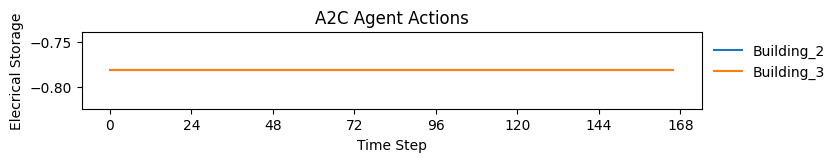

In [329]:
a2c_actions_list
plot_actions(a2c_actions_list,'A2C')

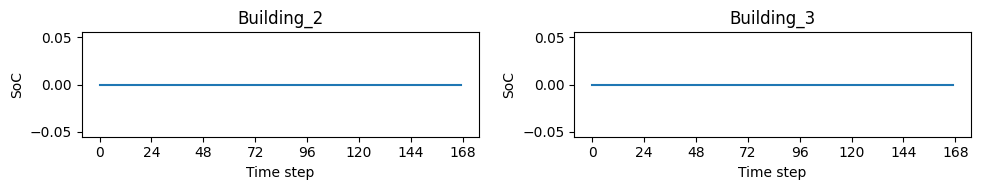

In [330]:
plot_soc(ac_env)

In [331]:
## KPIs
kpis = ac_env.evaluate()
kpi_name = ['electricity_consumption', 'cost', 'carbon_emissions','average_daily_peak', 'ramping', '1 - load_factor']
kpis = kpis[(kpis['cost_function'].isin(kpi_name))].dropna()
kpis['value'] = kpis['value'].round(3)
kpis = kpis.rename(columns={'cost_function': 'kpi'})

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:517: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



In [332]:
kpis

,kpi,value,name,level
0,1 - load_factor,1.0,District,district
1,average_daily_peak,1.0,District,district
2,carbon_emissions,1.0,District,district
3,cost,1.0,District,district
4,electricity_consumption,1.0,District,district
6,ramping,1.0,District,district
8,electricity_consumption,1.0,Building_2,building
10,carbon_emissions,1.0,Building_2,building
11,cost,1.0,Building_2,building
12,electricity_consumption,1.0,Building_3,building


In [ ]:
help(ac_env.reward_function)

Help on RewardFunction in module citylearn.reward_function object:

class RewardFunction(builtins.object)
 |  RewardFunction(env: citylearn.citylearn.CityLearnEnv, **kwargs)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, env: citylearn.citylearn.CityLearnEnv, **kwargs)
 |      Initialize `Reward`.
 |      
 |      Parameters
 |      ----------
 |      env: citylearn.citylearn.CityLearnEnv
 |          Simulation environment.
 |      **kwargs : dict
 |          Other keyword arguments for custom reward calculation.
 |  
 |  calculate(self) -> List[float]
 |      Calculates default reward.
 |      
 |      The default reward is the electricity consumption from the grid at the current time step returned as a negative value.
 |      
 |      Notes
 |      -----
 |      Reward value is calculated as :math:`[\textrm{min}(-e_0, 0), \dots, \textrm{min}(-e_n, 0)]` 
 |      where :math:`e` is `electricity_consumption` and :math:`n` is the number of agents.
 |  
 |  -----------------------

In [335]:
ac2_env = CityLearnEnv(schema)
ac2_env.reward_function = SolarPenaltyReward(ac2_env)
ac2_env = NormalizedObservationWrapper(ac2_env)
ac2_env = StableBaselines3Wrapper(ac2_env)

a2c_model2 = A2C('MlpPolicy', ac2_env, seed=20,verbose=0, gamma=0.99, learning_rate=0.0007,ent_coef=0.01)
a2c_callback2 = Callback(env=ac2_env)
a2c_model2 = a2c_model2.learn(total_timesteps=20000,callback=a2c_callback2)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning:

WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning:

WARN: Function `e

In [336]:
# a2c_callback2.reward_history
obs = ac2_env.reset()
a2c_actions2 = []
a2c_rewards2 = []

while not ac2_env.done:
    actions, _ = a2c_model2.predict(obs, deterministic=True)
    obs, rewards, _, _ = ac2_env.step(actions)
    a2c_actions2.append(actions)
    a2c_rewards2.append(rewards)

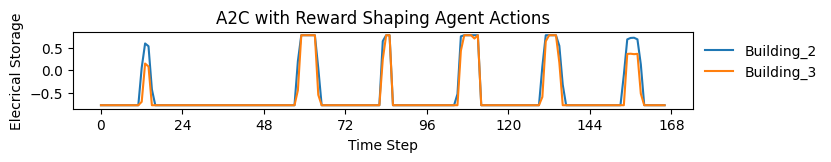

In [337]:
plot_actions(a2c_actions2,'A2C with Reward Shaping')

In [338]:

# a2c_rewards2
a2c_callback.reward_history

[-329.1554244506665,
 -241.08554424959644,
 -215.50422144632063,
 -186.75153826258398,
 -180.81135890188307,
 -172.47057278500017,
 -178.426145852043,
 -176.9541621653052,
 -172.71055965543604,
 -174.828288889567,
 -172.04412222290037,
 -175.22325067342118,
 -172.04412222290037,
 -172.04412222290037,
 -172.5523661304753,
 -178.02231123248995,
 -178.04705217417398,
 -181.3631254688053,
 -187.13384095156,
 -188.10997178279212,
 -183.45322448584722,
 -180.62629596757165,
 -185.25651454198874,
 -176.13756993074384,
 -179.0166602023442,
 -175.68451702611273,
 -172.04412222290037,
 -172.34775680171526,
 -172.52232734052598,
 -175.3414988770675,
 -172.05151437612315,
 -172.04412222290037,
 -172.04412222290037,
 -172.04412222290037,
 -172.04412222290037,
 -172.04412222290037,
 -171.79263888956703,
 -176.209088889567,
 -172.0922192029535,
 -172.16358236771484,
 -172.47664646273603,
 -172.04412222290037,
 -172.04412222290037,
 -172.04412222290037,
 -172.04412222290037,
 -172.04412222290037,
 -17

In [351]:
## KPIs
kpis = ac2_env.evaluate()
kpi_name = ['electricity_consumption', 'cost', 'carbon_emissions','average_daily_peak', 'ramping', '1 - load_factor']
kpis = kpis[(kpis['cost_function'].isin(kpi_name))].dropna()
kpis['value'] = kpis['value'].round(3)
kpis = kpis.rename(columns={'cost_function': 'kpi'})
kpis

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:517: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



,kpi,value,name,level
0,1 - load_factor,0.998,District,district
1,average_daily_peak,1.398,District,district
2,carbon_emissions,1.152,District,district
3,cost,1.036,District,district
4,electricity_consumption,1.147,District,district
6,ramping,1.745,District,district
8,electricity_consumption,1.146,Building_2,building
10,carbon_emissions,1.150,Building_2,building
11,cost,0.984,Building_2,building
12,electricity_consumption,1.149,Building_3,building


In [237]:
## SAVE THE MODEL
a2c_model2.save('a2c_model2')

## Load Model
# aa_model = stable_baselines3.A2C.load('saved_model/a2c_model2', ac2_env)

In [ ]:
#

## PPO

In [340]:
ppo_env = CityLearnEnv(schema)
# env.reward_function = CustomReward(env)
ppo_env = NormalizedObservationWrapper(ppo_env)
ppo_env = StableBaselines3Wrapper(ppo_env)

ppo_model = PPO('MlpPolicy', ppo_env, learning_rate=0.0007, seed=0,gamma= 0.99)

ppo_callback = Callback(env=ppo_env)
ppo_model = ppo_model.learn(total_timesteps=20000, callback=ppo_callback)




/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning:

WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning:

WARN: Function `e

In [341]:
ppo_callback.reward_history

[-305.77395751951184,
 -287.19612657910454,
 -313.94304410506874,
 -315.2760194299691,
 -299.1092842644224,
 -274.12992895715405,
 -303.8627989026525,
 -328.84819115489034,
 -312.6703691023192,
 -302.11216900230096,
 -291.04407290967544,
 -325.48953384006177,
 -343.6246328922299,
 -312.2201412559811,
 -299.9555195643739,
 -327.5740441541362,
 -290.1424462187323,
 -291.47003063017706,
 -295.9905100078276,
 -311.1022642490355,
 -287.4288081044281,
 -322.91061293837373,
 -292.4013904289059,
 -328.6777395941012,
 -291.73088197135905,
 -311.3504975070355,
 -280.9631178638763,
 -295.9862021393603,
 -302.8550463172918,
 -306.7185458570453,
 -303.0844389157658,
 -293.66724370341944,
 -264.92345203756713,
 -272.78011179534417,
 -282.33048780646493,
 -289.48265308226036,
 -285.82741008693176,
 -306.57325634030497,
 -276.44532114554283,
 -312.04004243185983,
 -308.0507255879431,
 -312.11851963904724,
 -307.60257830550364,
 -278.68611706200664,
 -315.5493045942909,
 -279.4300163642988,
 -326.41178

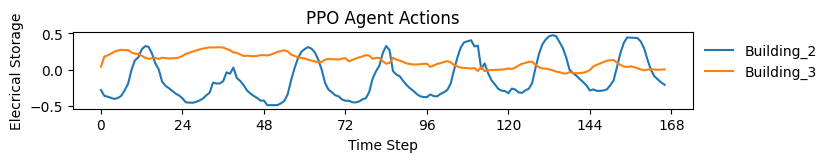

In [342]:
# evaluate agent
observations = ppo_env.reset()
actions_list = []

while not ppo_env.done:
    actions, _ = ppo_model.predict(observations, deterministic=True)
    observations, _, _, _ = ppo_env.step(actions)
    actions_list.append(actions)

plot_actions(actions_list,'PPO')

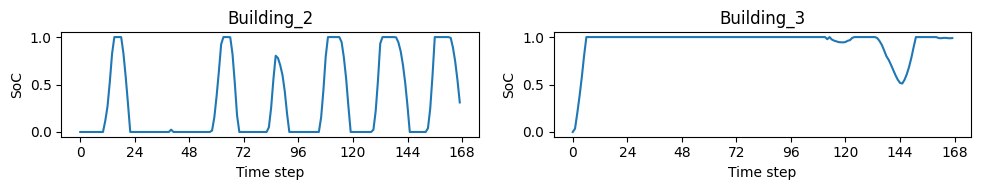

In [343]:
plot_soc(ppo_env)

In [344]:
kpis = ppo_env.evaluate()
kpi_name = ['electricity_consumption', 'cost', 'carbon_emissions','average_daily_peak', 'ramping', '1 - load_factor']
kpis = kpis[(kpis['cost_function'].isin(kpi_name))].dropna()
kpis['value'] = kpis['value'].round(3)
kpis = kpis.rename(columns={'cost_function': 'kpi'})
kpis

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:517: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



,kpi,value,name,level
0,1 - load_factor,0.984,District,district
1,average_daily_peak,0.968,District,district
2,carbon_emissions,0.992,District,district
3,cost,0.947,District,district
4,electricity_consumption,0.994,District,district
6,ramping,1.056,District,district
8,electricity_consumption,0.895,Building_2,building
10,carbon_emissions,0.887,Building_2,building
11,cost,0.832,Building_2,building
12,electricity_consumption,1.094,Building_3,building


In [345]:
ppo_env2 = CityLearnEnv(schema)
ppo_env2.reward_function = SolarPenaltyReward(ppo_env2)
# ppo_env2.reward_function = SolarPenaltyReward(ppo_env)
ppo_env2 = NormalizedObservationWrapper(ppo_env2)
ppo_env2 = StableBaselines3Wrapper(ppo_env2)

ppo_model2 = PPO('MlpPolicy', ppo_env2, learning_rate=0.0005, seed=0,gamma= 0.99)

ppo_callback2 = Callback(env=ppo_env2)
ppo_model2 = ppo_model2.learn(total_timesteps=20000, callback=ppo_callback2)




/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning:

WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.

/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning:

WARN: Function `e

In [346]:
ppo_callback2.reward_history

[-232.34134921240008,
 -222.84068027001078,
 -262.65332234489347,
 -214.8531393553157,
 -220.6234629351847,
 -207.32337500045105,
 -218.87550732797627,
 -240.72773444480677,
 -223.88736764326103,
 -208.16694286630897,
 -212.3244849051438,
 -241.8065906944784,
 -239.91455351211,
 -220.28641124509483,
 -221.2162504602682,
 -210.85407514515416,
 -211.19924755058213,
 -195.25191990000587,
 -212.62392330067314,
 -215.5267038429468,
 -207.44749439546746,
 -237.20047897866183,
 -204.67424141165844,
 -220.65711801517614,
 -210.1927272540048,
 -216.8547960025058,
 -210.7271796929082,
 -217.31294957331784,
 -210.453693385629,
 -204.07124880537694,
 -212.5479973346311,
 -218.26209076137647,
 -199.38975199222605,
 -192.53299218735728,
 -200.76261179124228,
 -208.24187048269047,
 -204.90809196661635,
 -213.19490599493403,
 -194.57061222885415,
 -217.6872905299304,
 -214.72334097659208,
 -223.24157135604574,
 -225.67533565907087,
 -210.02710812433708,
 -223.27907773293393,
 -194.00338730928505,
 -20

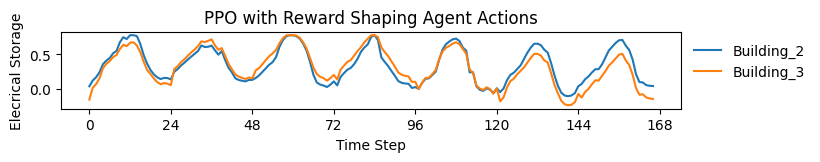

In [347]:
# evaluate agent
observations = ppo_env2.reset()
actions_list = []

while not ppo_env2.done:
    actions, _ = ppo_model2.predict(observations, deterministic=True)
    observations, _, _, _ = ppo_env2.step(actions)
    actions_list.append(actions)

plot_actions(actions_list,'PPO with Reward Shaping')

In [348]:
kpis = ppo_env2.evaluate()
kpi_name = ['electricity_consumption', 'cost', 'carbon_emissions','average_daily_peak', 'ramping', '1 - load_factor']
kpis = kpis[(kpis['cost_function'].isin(kpi_name))].dropna()
kpis['value'] = kpis['value'].round(3)
kpis = kpis.rename(columns={'cost_function': 'kpi'})
kpis

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:517: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



,kpi,value,name,level
0,1 - load_factor,0.987,District,district
1,average_daily_peak,1.205,District,district
2,carbon_emissions,1.096,District,district
3,cost,1.054,District,district
4,electricity_consumption,1.094,District,district
6,ramping,1.108,District,district
8,electricity_consumption,1.088,Building_2,building
10,carbon_emissions,1.090,Building_2,building
11,cost,1.058,Building_2,building
12,electricity_consumption,1.099,Building_3,building


## Plots

In [212]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio


/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:517: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning:

np.find_common

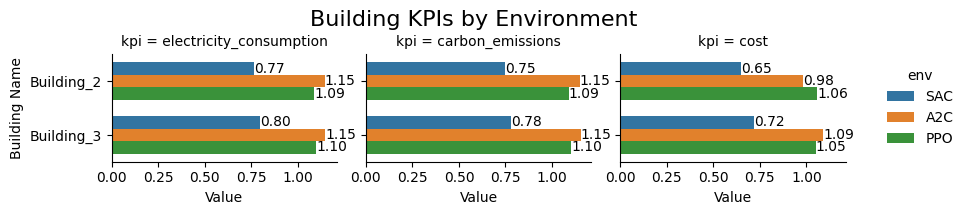

In [353]:
# envs = {'SAC': sac_env,'A2C':ac_env,'PPO':ppo_env}
envs = {'SAC': sac2_env ,'A2C':ac2_env,'PPO':ppo_env2}

kpis_list = []

for k, v in envs.items():
  kpis = v.evaluate()
  kpi_name = ['electricity_consumption', 'cost', 'carbon_emissions','average_daily_peak', 'ramping', '1 - load_factor']
  kpis = kpis[(kpis['cost_function'].isin(kpi_name))].dropna()
  kpis['value'] = kpis['value'].round(3)
  kpis = kpis.rename(columns={'cost_function': 'kpi'})
  kpis = kpis[kpis['level']=='building'].copy() ## get only building level kpis
  kpis['building_num'] = kpis['name'].str.split('_', expand=True)[1]
  kpis['building_num'] = kpis['building_num'].astype(int).astype(str)
  kpis['env'] = k
  kpis_list.append(kpis)

data = pd.concat(kpis_list)

g = sns.catplot(data=data,x='value',y='name',
                hue='env',col='kpi',kind='bar',width=0.7,orientation='horizontal',
                height=2,aspect=1.5,legend_out=True,margin_titles=True)
for ax in g.axes.flat:
  for p in ax.patches:
    bar_value = p.get_width()
    ax.text(
      bar_value, p.get_y() + p.get_height()/2, f'{bar_value:.2f}',
      va='center',
      ha='left'
    )
g.set_axis_labels("Value", "Building Name")

plt.suptitle('Building KPIs by Environment', y=1.05, fontsize=16)
plt.savefig('building_kpi_after.png',dpi=900,bbox_inches='tight')
plt.show()


In [373]:
envs = {'SAC': sac_env,'A2C':ac_env,'PPO':ppo_env}
# envs = {'SAC': sac2_env ,'A2C':ac2_env,'PPO':ppo_env2}

kpis_list = []

for k, v in envs.items():
  kpis = v.evaluate()
  kpi_name = ['electricity_consumption', 'cost', 'carbon_emissions','average_daily_peak', 'ramping', '1 - load_factor']
  kpis = kpis[(kpis['cost_function'].isin(kpi_name))].dropna()
  kpis['value'] = kpis['value'].round(3)
  kpis = kpis.rename(columns={'cost_function': 'kpi'})
  kpis = kpis[kpis['level']=='district'].copy()
  kpis['env'] = k
  kpis_list.append(kpis)

data = pd.concat(kpis_list)
fig = px.bar(
    data,x='value',y='name',color='env',orientation='h',barmode='group',
    facet_col='kpi',title='District KPIs by Environment',width=1300,
    height=400,facet_row_spacing=0.1,text='value',
    labels={'value': 'Value', 'kpi': 'KPI', 'env': 'Environment'}
)

# Display the plot
fig.show()

/usr/local/lib/python3.10/dist-packages/pandas/core/algorithms.py:517: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



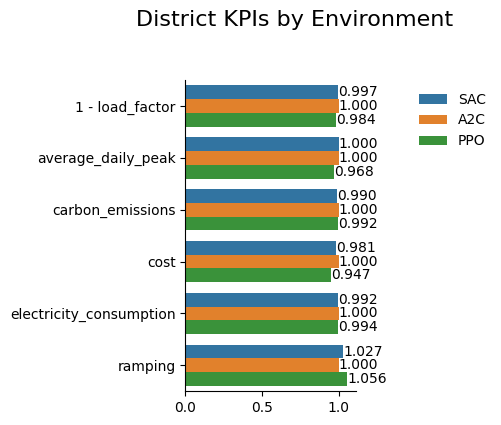

In [374]:
figsize = (6,4)
fig, ax = plt.subplots(1, 1, figsize=figsize)

sns.barplot(x='value', y='kpi', data=data, hue='env', ax=ax)
ax.set_xlabel(None)
ax.set_ylabel(None)

for spine in ['right', 'top']:
  ax.spines[spine].set_visible(False)

for p in ax.patches:
  ax.text(
      p.get_x() + p.get_width(),
      p.get_y() + p.get_height()/2,
      f'{p.get_width():.3f}',
      ha='left',
      va='center'
  )

ax.legend(loc='upper left', bbox_to_anchor=(1.3, 1.0), framealpha=0.0)
plt.suptitle('District KPIs by Environment', y=1.05, fontsize=16)
plt.savefig('district_kpi_before.png',dpi=900,bbox_inches='tight')
plt.tight_layout()
plt.show()


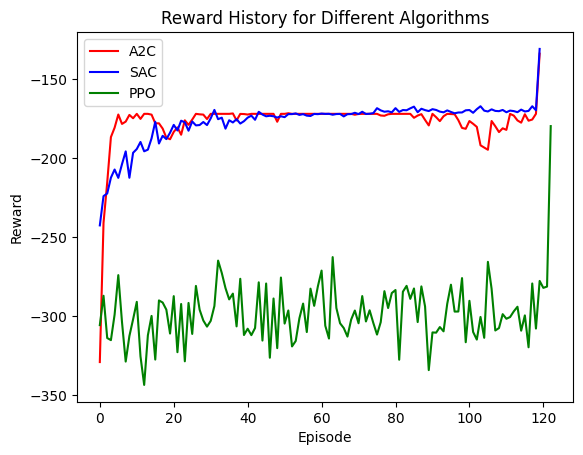

In [355]:
a2c_rewards = a2c_callback.reward_history
sac_rewards = sac_callback.reward_history
ppo_rewards = ppo_callback.reward_history

# a2c_rewards = a2c_callback2.reward_history
# sac_rewards = sac2_callback.reward_history
# ppo_rewards = ppo_callback2.reward_history

x_a2c = list(range(len(a2c_rewards)))
x_sac = list(range(len(sac_rewards)))
x_ppo = list(range(len(ppo_rewards)))

plt.plot(x_a2c, a2c_rewards, label='A2C', color='red')
plt.plot(x_sac, sac_rewards, label='SAC', color='blue')
plt.plot(x_ppo, ppo_rewards, label='PPO', color='green')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward History for Different Algorithms')
plt.legend()
plt.savefig('rewards_before_rs.png',dpi=900)
plt.show()


In [214]:
len(sac_callback.reward_history)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



120

## SARSA

In [377]:
sars_schema = schema

buildings = list(sars_schema['buildings'].keys())
buildings = buildings[1:2]
print(buildings)
for b in sars_schema['buildings']:
    if b in buildings:
        sars_schema['buildings'][b]['include'] = True
    else:
        sars_schema['buildings'][b]['include'] = False

['Building_2']


In [378]:
active_obs = ['hour']
for obs in sars_schema['observations']:
    if obs in active_obs:
        sars_schema['observations'][obs]['active'] = True
    else:
        sars_schema['observations'][obs]['active'] = False

In [405]:
sars_env = CityLearnEnv(sars_schema)
a2c_dis_env = CityLearnEnv(sars_schema)
ppo_dis_env = CityLearnEnv(sars_schema)
sac_dis_env = CityLearnEnv(sars_schema)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning:

np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)



In [406]:
## Discretize Obs and Actions for simplification of problem
obs_bins = {'hour':24}
action_bins = {'electrical_storage':12}

obs_bin_size = []
action_bin_size = []
for building in sars_env.buildings:
  obs_bin_size.append(obs_bins)
  action_bin_size.append(action_bins)

sars_env = DiscreteSpaceWrapper(sars_env.unwrapped, observation_bin_sizes=obs_bin_size, action_bin_sizes=action_bin_size)
a2c_dis_env = DiscreteSpaceWrapper(a2c_dis_env.unwrapped, observation_bin_sizes=obs_bin_size, action_bin_sizes=action_bin_size)
ppo_dis_env = DiscreteSpaceWrapper(ppo_dis_env.unwrapped, observation_bin_sizes=obs_bin_size, action_bin_sizes=action_bin_size)
sac_dis_env = DiscreteSpaceWrapper(sac_dis_env.unwrapped, observation_bin_sizes=obs_bin_size, action_bin_sizes=action_bin_size)

In [391]:
sars_env.action_space

[MultiDiscrete([12])]

In [382]:
sars_env.observation_space

[MultiDiscrete([24])]

In [234]:
import tensorflow as tf
import random

tf.get_logger().setLevel('ERROR')

class SARSA:
    def __init__(self, env, state_dim, action_space, learning_rate=0.001, discount_factor=0.99, epsilon=0.1):
      self.env = env
      self.state_dim = state_dim
      self.action_space = action_space
      self.action_dims = 12
      self.learning_rate = learning_rate
      self.discount_factor = discount_factor
      self.epsilon = epsilon

      self.model = self.create_model()

    def create_model(self):
      model = tf.keras.Sequential([
          tf.keras.layers.Dense(64, activation='relu', input_shape=(self.state_dim,)),
          tf.keras.layers.Dense(64, activation='relu'),
          tf.keras.layers.Dense(np.prod(self.action_dims))  # number of outputs = number of actions
      ])
      model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate), loss='mse')
      return model

    def select_action(self, state):
      # Epsilon-greedy
      if np.random.rand() < self.epsilon:
          action = random.randint(0, 11)
          # print('eps_greedy')
          return [[action]]
      else:
          # q_values = self.model.predict(np.array([state]))[0]
          q_values = self.model.predict(np.array([state]))
          actions = []
          action1 = np.argmax(q_values[0])
          actions.append(action1)

          return [actions]


    def update_sarsa(self, state, action, reward, next_state, next_action):
      current_q = self.model.predict(np.array([state]))[0]
      next_q= self.model.predict(np.array([next_state]))[0]

      # print(reward)
      # print(next_q_values)
      # print('next_action:', next_action)
      # print(next_q_values[next_action])
      target_q_value = reward + self.discount_factor * next_q[next_action]
      # print("current",current_q_values)
      # print("current[ actopn]",current_q_values[action])
      # print('target',target_q_value)
      # Update the Q-values for the chosen action
      current_q[action] = target_q_value


      # self.model.train_on_batch(np.array([state]), np.array([current_q_values]))
      state_input = np.array([state])

      target_input = np.array([current_q])
      # self.model.train_on_batch(np.array([state]), current_q_values)
      # train with updated q-vals
      self.model.train_on_batch(state_input, target_input)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [235]:
# Initialize the SARSA agent
state_dim = sars_env.observation_space[0].shape[0]
action_space = sars_env.action_space
sarsa_agent = SARSA(sars_env, state_dim, action_space)

In [ ]:
# Training loop
num_episodes = 120
ep_rewards = []
for episode in range(num_episodes):
  state = sars_env.reset()
  episode_reward = 0
  terminal = False

  action = sarsa_agent.select_action(state)

  while not terminal:
      # Step the environment with the selected action
      next_state, reward, terminal, _ = sars_env.step(action)
      episode_reward += reward[-1]
      # print(reward)
      next_action = sarsa_agent.select_action(next_state)

      sarsa_agent.update_sarsa(state, action, reward[-1], next_state, next_action)

      state = next_state
      action = next_action

  print(f"Episode {episode + 1}: Total Reward: {episode_reward}")
  ep_rewards.append(episode_reward)

print("Training complete.")


In [394]:
a2c_dis_env.action_space

[MultiDiscrete([12])]

In [395]:
# ## A2C
# class Callback(BaseCallback):
#   def __init__(self, env:CityLearnEnv):
#     super().__init__(verbose=0)
#     self.env = env
#     self.reward_history = [0]
#   ## keep track of the rewards
#   def _on_step(self) -> bool:
#     # if self.env.time_step == 0:
#     #     self.reward_history.append(0)
#     # else:
#     self.reward_history[-1] += sum(self.env.rewards[-1])
#     return True

a2c_dis_env = StableBaselines3Wrapper(a2c_dis_env)

a2c_dis_model = A2C('MlpPolicy', env=a2c_dis_env, learning_rate=0.0005, seed=0,gamma= 0.99)

a2c_callback3 = Callback(env=a2c_dis_env)
a2c_dis_model = a2c_dis_model.learn(total_timesteps=20000, callback=a2c_callback3)


/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning:

WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.



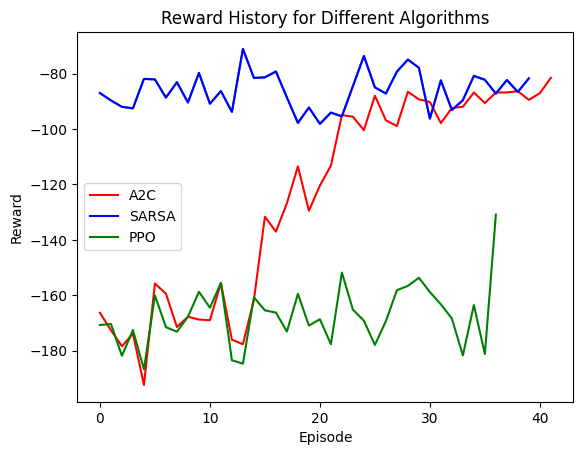

In [ ]:
eps = [x for x in range(120)]
fig, ax = plt.subplots()
ax.plot(eps,ep_rewards)
ax.set_xlabel("Episodes")
ax.set_ylabel("Rewards")
ax.set_title("SARSA")

a2c_rewards = a2c_callback3.reward_history
sarsa_rewards = ep_rewards
ppo_rewards = ppo_callback3.reward_history

# a2c_rewards = a2c_callback2.reward_history
# sac_rewards = sac2_callback.reward_history
# ppo_rewards = ppo_callback2.reward_history

x_a2c = list(range(len(a2c_rewards)))
x_sac = list(range(len(sarsa_rewards)))
x_ppo = list(range(len(ppo_rewards)))

plt.plot(x_a2c, a2c_rewards, label='A2C', color='red')
plt.plot(x_sac, sarsa_rewards, label='SARSA', color='blue')
plt.plot(x_ppo, ppo_rewards, label='PPO', color='green')

plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Reward History for Different Algorithms')
plt.legend()
plt.savefig('rewards_sarsa.png',dpi=900)
plt.show()


In [ ]:
a2c_callback3.reward_history

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



[-166.37553266623488,
 -172.6583901172606,
 -178.44293445424907,
 -173.89112178951223,
 -192.40704047808737,
 -155.78968488157543,
 -159.45037183105097,
 -171.50700808119808,
 -167.7783948575294,
 -168.8083445202859,
 -169.03254674783776,
 -155.66011805366185,
 -176.0951220621107,
 -177.6969518430257,
 -161.65737797336607,
 -131.6568537265898,
 -137.04827787541907,
 -126.78164480603627,
 -113.49436864199728,
 -129.50252539247168,
 -120.41980245398157,
 -113.21564461634644,
 -94.94929714930234,
 -95.54327445470594,
 -100.40636837184617,
 -87.94460718264067,
 -96.84248516219975,
 -98.91614612145538,
 -86.50720633806425,
 -89.28279275201699,
 -90.22264525491502,
 -97.8375917954936,
 -92.42419990942908,
 -91.94409401801273,
 -86.79528306319389,
 -90.60950968931114,
 -86.81330378787882,
 -86.77574257976093,
 -86.34395938479896,
 -89.4649578904352,
 -87.03156634565968,
 -81.50385306303797]

In [ ]:
## PPO
# ppo_env2 = CityLearnEnv(schema)
# ppo_env2.reward_function = CustomReward(ppo_env2)
# ppo_env2.reward_function = SolarPenaltyReward(ppo_env)
# ppo_env2 = NormalizedObservationWrapper(ppo_env2)
# ppo_dis_env = StableBaselines3Wrapper(ppo_dis_env)

ppo_model_dis = PPO('MlpPolicy', ppo_dis_env, learning_rate=0.0005, seed=0,gamma= 0.99)

ppo_callback3 = Callback(env=ppo_dis_env)
ppo_model_dis = ppo_model_dis.learn(total_timesteps=20000, callback=ppo_callback3)

In [ ]:
ppo_callback3.reward_history

[-170.77123693920643,
 -170.41309393620105,
 -181.89114244891616,
 -172.59445216310613,
 -186.77582935615413,
 -160.07851243018888,
 -171.54789463744584,
 -173.20304886542417,
 -167.77839694330746,
 -158.77795073469306,
 -164.5324499462218,
 -155.54171899383644,
 -183.51337163600058,
 -184.73192906144627,
 -160.77375985202445,
 -165.4844369940563,
 -166.28238886437887,
 -173.12812905424752,
 -159.50178994863225,
 -170.97641749407543,
 -168.68912458629137,
 -177.70062836698457,
 -151.83627554489956,
 -165.19931914444703,
 -169.21190945132037,
 -177.95614110014844,
 -169.36104188451202,
 -158.20256248011682,
 -156.6409937930438,
 -153.70557161707924,
 -158.86180962511816,
 -163.31571591156776,
 -168.4425295848607,
 -181.7669907393616,
 -163.53642875691725,
 -181.25659157440404,
 -130.9056971929577]

## DQN

In [ ]:
dqn_schema = schema

buildings = list(dqn_schema['buildings'].keys())
buildings = buildings[1:3]
print(buildings)
for b in dqn_schema['buildings']:
    if b in buildings:
        dqn_schema['buildings'][b]['include'] = True
    else:
        dqn_schema['buildings'][b]['include'] = False

['Building_2', 'Building_3']


In [ ]:
active_obs = ['hour']
for obs in dqn_schema['observations']:
    if obs in active_obs:
        dqn_schema['observations'][obs]['active'] = True
    else:
        dqn_schema['observations'][obs]['active'] = False

In [ ]:
dqn_env = CityLearnEnv(dqn_schema)

/usr/local/lib/python3.10/dist-packages/pandas/core/dtypes/cast.py:1846: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])  # type: ignore[arg-type]


In [ ]:
## Discretize Obs and Actions for simplification of problem
obs_bins = {'hour':24}
action_bins = {'electrical_storage':12}

obs_bin_size = []
action_bin_size = []
for building in dqn_env.buildings:
  obs_bin_size.append(obs_bins)
  action_bin_size.append(action_bins)

dqn_env = DiscreteSpaceWrapper(dqn_env.unwrapped, observation_bin_sizes=obs_bin_size, action_bin_sizes=action_bin_size)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
dqn_env.action_space


[MultiDiscrete([12 12])]

In [ ]:
dqn_env.observation_space

[MultiDiscrete([24])]

In [ ]:
import tensorflow as tf
# dqn_env.action_space # [MultiDiscrete([12 12])]
# dqn_env.observation_space #[MultiDiscrete([24])]

class DQN:
  def __init__(self, env,state_dim, action_dim, learning_rate=0.0001, discount=0.99,epsilon= 0.1,replay_buffer_size=10000,batch_size=3):
    self.env = env
    self.state_dim = state_dim
    self.action_dim = action_dim
    self.learning_rate = learning_rate
    self.discount = discount
    self.epsilon = epsilon
    self.replay_buffer = []
    self.replay_buffer_size = replay_buffer_size
    self.batch_size = batch_size

    self.main_model = self.create_model()
    self.target_model = self.create_model()
    self.update_target()

  def create_model(self):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64,activation='relu',input_shape=(self.state_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(12)])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate),loss='mse')
    return model

  def update_target(self):
    self.target_model.set_weights(self.main_model.get_weights())

  # def choose_action(self,state):
  #   if np.random.rand() < self.epsilon:
  #     # exploration
  #     return random.randint(0, self.action_dim - 1)
  #   else:
  #     # get max q-value over actions
  #     q_values = self.main_model.predict(np.array([state]))
  #     return np.argmax(q_values[0])

  def choose_action(self, state):
    if np.random.rand() < self.epsilon:
        actions = [random.randint(0, 11) for _ in range(len(self.env.buildings))]
    else:
        q_values = self.main_model.predict(np.array([state]))
        # print(q_values)

        actions = []
        # num_buildings = len(self.env.buildings)
        # print(np.argmax(q_values[0]))
        # print(q_values[0][12:])
        action1 = np.argmax(q_values[0])
        action2 = np.argmax(q_values[0])
        actions.append(action1)
        actions.append(action2)

    return [actions]


  def store(self,state,action,reward,next_s,terminal):
    self.replay_buffer.append((state,action,reward,next_s,terminal))

  def train(self):
    if len(self.replay_buffer) < self.batch_size:
          return
    batch = random.sample(self.replay_buffer,self.batch_size)
    states, actions, rewards, next_states, terminals = zip(*batch)
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards)
    next_states = np.array(next_states)
    terminals = np.array(terminals)

    q_vals = self.main_model.predict(states)
    future_q_vals = self.target_model.predict(next_states)
    target_q_vals = np.zeros_like(rewards)

    for i in range(len(rewards)):
      if not terminals[i]:
          target_q_vals[i] = rewards[i] + self.discount * np.max(future_q_vals[i])
      else: # end of episode
          target_q_vals[i] = rewards[i]

    actions = actions.reshape((self.batch_size, 2))

    q_vals[np.arange(self.batch_size), actions[:, 0]] = target_q_vals[:, 0]
    q_vals[np.arange(self.batch_size), actions[:, 1]] = target_q_vals[:, 1]

    # q_vals[np.arange(self.batch_size),actions] = target_q_vals

    self.main_model.train_on_batches(states,q_vals)





In [ ]:
state_dim = len(dqn_env.observation_space[0])
action_dim = dqn_env.action_space[0].shape[0]
print(state_dim,action_dim)
dqn_agent = DQN(env=dqn_env, state_dim=state_dim, action_dim=action_dim)

In [ ]:
num_eps = 120 # rounds of simulation of 7 days
update_target_freq = 10

for ep in range(num_eps):
  s = dqn_env.reset()
  ep_reward = 0
  terminal = False
  steps = 0
  # print(s)
  while not terminal:
    action = dqn_agent.choose_action(s)
    # print(action)
    next_s, reward, terminal, _ = dqn_env.step(action)
    # print(reward)
    ep_reward += reward[-1]

    dqn_agent.store(s,action,reward,next_s,terminal)
    # print(dqn_agent.replay_buffer)

    dqn_agent.train()

    if steps % update_target_freq == 0:
      dqn_agent.update_target()

    s = next_s
    steps += 1
  print(f'Episode {ep}, Total Reward: {ep_reward}')
